# This is the simulation of the Linear Model

In [23]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import StateSpace, lsim
from torch import nn
import torch
import torchvision
plt.rcParams.update({
    "text.usetex": True,
    })


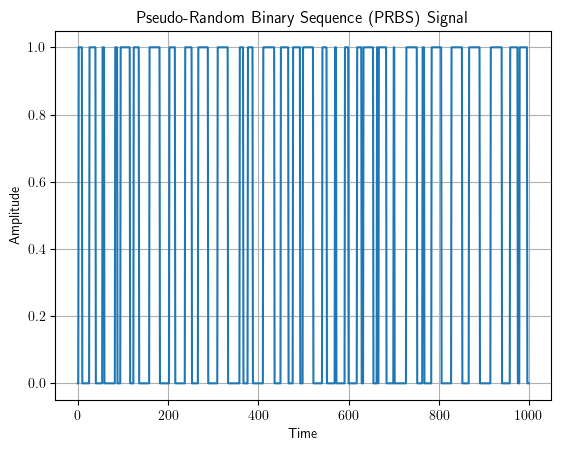

In [80]:
import numpy as np
import matplotlib.pyplot as plt

def generate_prbs_signal(num_samples, min_hold_time, max_hold_time):
    signal = np.zeros(num_samples)
    time = 0
    hold = min_hold_time
    
    for i in range(1, num_samples):
        if time >= hold:
            signal[i] = 1 - signal[i - 1]
            hold = np.random.randint(min_hold_time, max_hold_time + 1)
            time = 0
        else:
            signal[i] = signal[i - 1]
            time += 1

    return signal

# Example parameters
num_samples = 1000
min_hold_time = 1  # Minimum hold time
max_hold_time = 25  # Maximum hold time

# Generate PRBS signal
prbs_signal = generate_prbs_signal(num_samples, min_hold_time, max_hold_time)

# Plot the PRBS signal
plt.plot(prbs_signal)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Pseudo-Random Binary Sequence (PRBS) Signal')
plt.grid(True)
plt.show()


In [25]:
# define the system

# Parameter festlegen
m1 = 1  # Masse 1
m2 = 2  # Masse 2
k1 = 10  # Federkonstante 1
k2 = 5  # Federkonstante 2
b1 = 0.5  # Reibung 1
b2 = 0.2  # Reibung 2

# Zustandsraummodell definieren
A = np.array([
    [0, 1, 0, 0],
    [-(k1/m1), -(b1/m1), k2/m1, 0],
    [0, 0, 0, 1],
    [k2/m2, 0, -(k2/m2), -(b2/m2)]
])

B = np.array([
    [0],
    [1],
    [0],
    [0]
])

C = np.array([
    [1, 0, -1, 0],
    [0, 0, 1, 0]
])

D = np.array([
    [0],
    [0]
])

In [26]:
# FUNKTION DIE SYSTEM MIT ZUFAELLIG NEUEN ANFANGSZUSTAENDEN SIMULIERT

def randomSystemRun(A,B,C,D,k):

    sys = StateSpace(A, B, C, D)

    number_samples = 4000
    T = 10      # 10sec
    t = np.linspace(0, T, number_samples)  # von 0 bis 10 Sekunden, 1000 Schritte
    # Anregungssignal (hier: keine Anregung)
    u = np.zeros(len(t))

    # Anfangszustand (hier: zufaellig zwischen -5 und 5
    x0 = np.random.randint((10,10,10,10))-5

    # System simulieren
    t_out, y_out, x_out = lsim(sys, U=u, T=t, X0=x0)

    # numpy array manipulation
    number_states = 4
    n = number_samples-k
    new_x = np.zeros((n,number_states*k))

    for i in range(n):
        new_x[i,:] = x_out[i:i+k].flatten()

    new_y = x_out[k:]

    input_tensor = torch.from_numpy(new_x).float()
    target_tensor = torch.from_numpy(new_y).float()

    input_tensor = input_tensor.unsqueeze(1)  # Adding a dimension to represent sequence length
    target_tensor = target_tensor.unsqueeze(1)  # Adding a dimension to represent sequence length

    return input_tensor, target_tensor, t

In [27]:
def plot4States(t,x_out):
    plt.plot(t,x_out[:,0],label='state 1')
    plt.plot(t,x_out[:,1],label='state 2')
    plt.plot(t,x_out[:,2],label='state 3')
    plt.plot(t,x_out[:,3],label='state 4')
    plt.legend()
    plt.show()

In [62]:
# neural network

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
has_gpu = torch.cuda.is_available()
has_mps = torch.backends.mps.is_built()
device = "mps"
device = torch.device(device)


class CustomRNNCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(CustomRNNCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        # Parameters for the RNN cell
        self.Wxh = nn.Linear(input_size, hidden_size)
        self.Whh = nn.Linear(hidden_size, hidden_size)

    def forward(self, x, h):
        combined = self.Wxh(x) + self.Whh(h)
        return torch.relu(combined)


class MultiLayerRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(MultiLayerRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Define a list of custom RNN cells
        self.rnn_cells = nn.ModuleList([CustomRNNCell(input_size if i == 0 else hidden_size, hidden_size)
                                        for i in range(num_layers)])
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        #batch_size = x.size(0) #alt, war falsch, wieso auch immer, hat den fehler verursacht mit den hohen dimensionalitaeten
        batch_size = 1
        #print(f'batch size = {batch_size}')    #zum debuggen benutzt

        # Initialize hidden state with zeros for each layer
        hidden_states = [torch.zeros(batch_size, self.hidden_size, device=device) for _ in range(self.num_layers)]
    
        # Forward through multiple RNN layers
        for layer_idx in range(self.num_layers):
            # Get the current RNN cell
            rnn_cell = self.rnn_cells[layer_idx]

            # Forward through the RNN cell
            hidden_states[layer_idx] = rnn_cell(x if layer_idx == 0 else hidden_states[layer_idx - 1],
                                                hidden_states[layer_idx])

        # Take the output from the last layer
        out = self.fc(hidden_states[-1])
        return out


In [63]:
# initialize the neural network and set hyperparams
number_states = 4
k = 1  # number of timesteps we look back 

input_dim = number_states * k
output_dim = number_states
hidden_dim = 8
num_layers = 2

model = MultiLayerRNN(input_dim, hidden_dim, output_dim, num_layers).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

In [64]:
## initiate training phase
number_systems = 10 #number of different systems we use to train oon

for i in range(number_systems):

    input_tensor, target_tensor, t = randomSystemRun(A,B,C,D,k)

    input_tensor = input_tensor.to(device)
    target_tensor = target_tensor.to(device)

    num_epochs = 500
    for epoch in range(num_epochs):
        optimizer.zero_grad()

        # Forward pass
        outputs = model(input_tensor)
        loss = criterion(outputs, target_tensor)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 100 == 0:
            print(f'Round {i+1}, Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}')


Round 1, Epoch [100/500], Loss: 0.09226954728364944
Round 1, Epoch [200/500], Loss: 0.04283791407942772
Round 1, Epoch [300/500], Loss: 0.007057172246277332
Round 1, Epoch [400/500], Loss: 0.003275440540164709
Round 1, Epoch [500/500], Loss: 0.0010434311116114259
Round 2, Epoch [100/500], Loss: 3.662201197585091e-05
Round 2, Epoch [200/500], Loss: 1.7564021845828393e-06
Round 2, Epoch [300/500], Loss: 0.00018236777395941317
Round 2, Epoch [400/500], Loss: 0.007861396297812462
Round 2, Epoch [500/500], Loss: 5.81063034132967e-07
Round 3, Epoch [100/500], Loss: 2.385655561987221e-11
Round 3, Epoch [200/500], Loss: 1.225801469877108e-12
Round 3, Epoch [300/500], Loss: 5.392487671673774e-13
Round 3, Epoch [400/500], Loss: 3.1737053306571394e-13
Round 3, Epoch [500/500], Loss: 3.192270937608238e-13
Round 4, Epoch [100/500], Loss: 3.226206857220859e-08
Round 4, Epoch [200/500], Loss: 3.476791050616157e-07
Round 4, Epoch [300/500], Loss: 1.1948316114285262e-06
Round 4, Epoch [400/500], Loss: 

In [65]:
### evaluate the model on test set

model.eval()

input_tensor_test, target_tensor_test, t = randomSystemRun(A,B,C,D,k)
input_tensor_test = input_tensor_test.to(device)
target_tensor_test = target_tensor_test.to(device)

# Get predictions from the model
with torch.no_grad():
    predicted_output = model(input_tensor_test)

# Convert predicted_output tensor to numpy array
predicted_output_np = predicted_output.cpu().numpy()
actual_target_np = target_tensor_test.cpu().numpy()


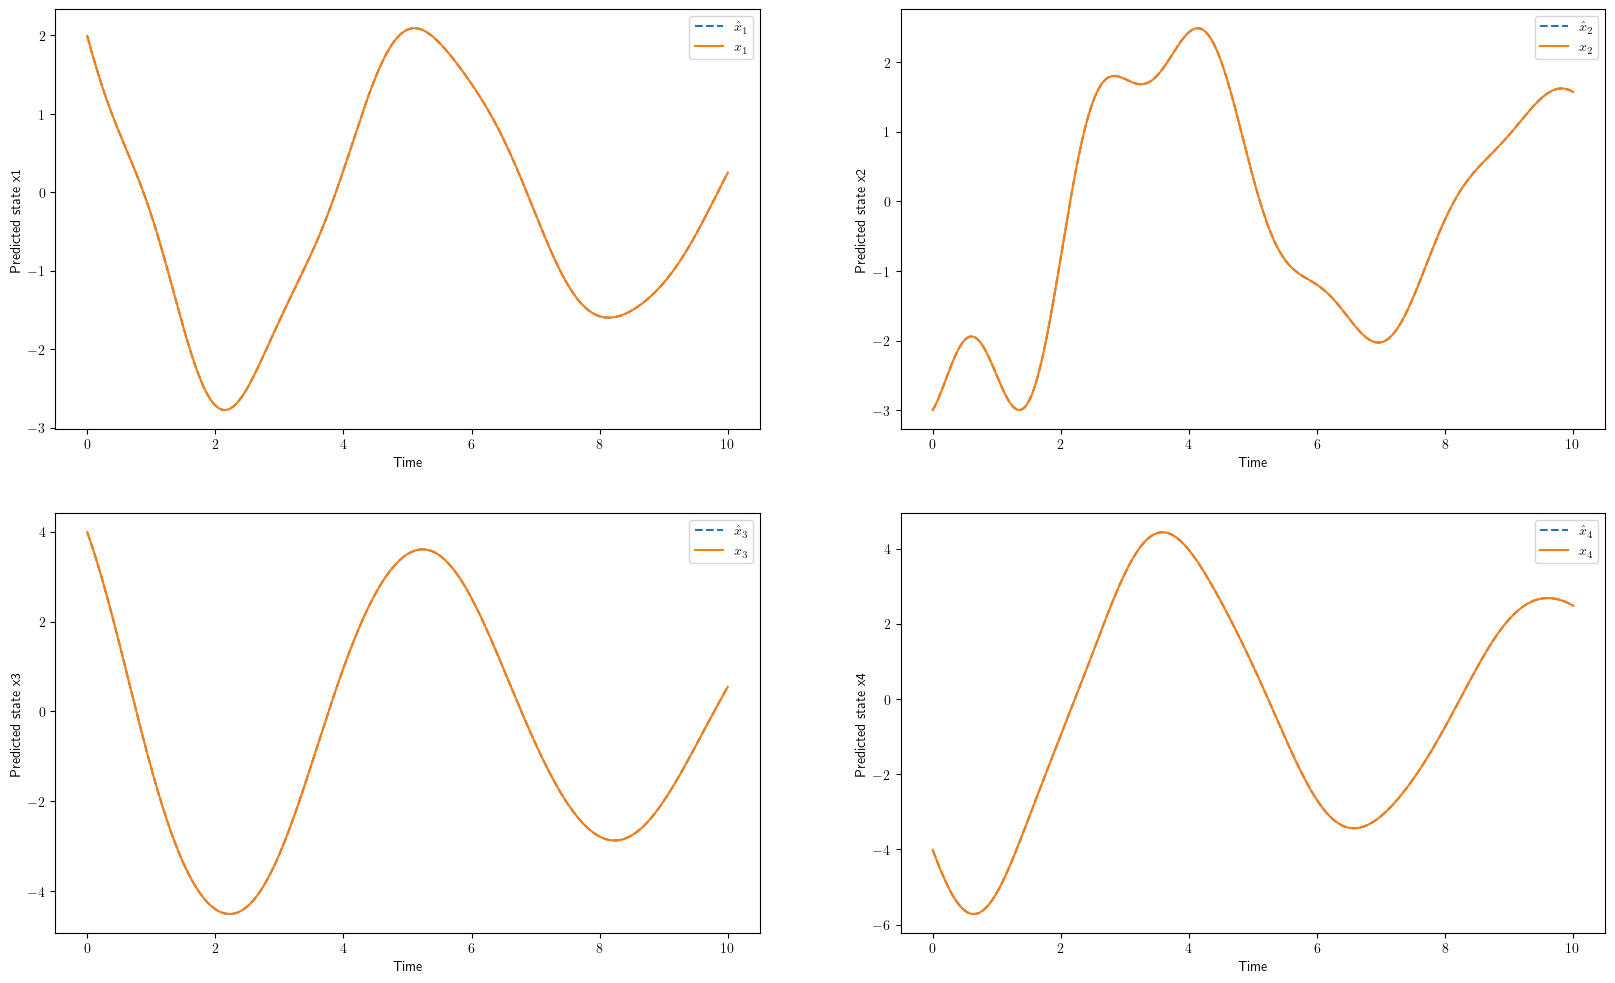

In [66]:
### plot the result of the test set

plt.figure(figsize=(20, 12))

plt.subplot(2,2,1)
plt.plot(t[k:],predicted_output_np[:,0,0], label=r'$\hat{x}_1$', linestyle='--')
plt.plot(t[k:],actual_target_np[:,0,0],label=r"$x_1$")
plt.xlabel('Time')
plt.ylabel('Predicted state x1')
plt.legend()

plt.subplot(2,2,2)
plt.plot(t[k:],predicted_output_np[:,0,1], label=r'$\hat{x}_2$', linestyle='--')
plt.plot(t[k:],actual_target_np[:,0,1],label=r"$x_2$")
plt.xlabel('Time')
plt.ylabel('Predicted state x2')
plt.legend()

plt.subplot(2,2,3)
plt.plot(t[k:],predicted_output_np[:,0,2], label=r'$\hat{x}_3$', linestyle='--')
plt.plot(t[k:],actual_target_np[:,0,2],label=r"$x_3$")
plt.xlabel('Time')
plt.ylabel('Predicted state x3')
plt.legend()  

plt.subplot(2,2,4)
plt.plot(t[k:],predicted_output_np[:,0,3], label=r'$\hat{x}_4$', linestyle='--')
plt.plot(t[k:],actual_target_np[:,0,3],label=r"$x_4$")
plt.xlabel('Time')
plt.ylabel('Predicted state x4')
plt.legend()

plt.show()